**Generic Programming**

[QuantEcon]("https://julia.quantecon.org/more_julia/generic_programming.html")

Taisei Noda

May/28/2020

**NOTE**

* Exercise 1b and exer

In [1]:
using InstantiateFromURL
# optionally add arguments to force installation: instantiate = true, precompile = true
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.7.0")

Activated /Users/taisei/Project.toml
Info quantecon-notebooks-julia 0.5.0 activated, 0.7.0 requested


In [2]:
using LinearAlgebra, Statistics
using Distributions, Plots, QuadGK, Polynomials, Interpolations

# Exploring Type Trees

## Subtype trees

In [3]:
using Distributions
x = 1
y = Normal()
z = "foo"
@show x, y, z
@show typeof(x), typeof(y), typeof(z)
@show supertype(typeof(x))

# pipe operator, |>, is is equivalent
@show typeof(x) |> supertype
@show supertype(typeof(y))
@show typeof(z) |> supertype
@show typeof(x) <: Any;

(x, y, z) = (1, Normal{Float64}(μ=0.0, σ=1.0), "foo")
(typeof(x), typeof(y), typeof(z)) = (Int64, Normal{Float64}, String)
supertype(typeof(x)) = Signed
typeof(x) |> supertype = Signed
supertype(typeof(y)) = Distribution{Univariate,Continuous}
typeof(z) |> supertype = AbstractString
typeof(x) <: Any = true


**pipe operator**  `|>` (`>%>` in R)

`function(x)` $\equiv$ `x |> function`

In [4]:
using Base:show_supertypes
show_supertypes(Int64)

Int64 <: Signed <: Integer <: Real <: Number <: Any

In [5]:
subtypes(Integer)

4-element Array{Any,1}:
 Bool
 GeometryTypes.OffsetInteger
 Signed
 Unsigned

In [6]:
#  from https://github.com/JuliaLang/julia/issues/24741
function subtypetree(t, level=1, indent=4)
        if level == 1
            println(t)
        end
        for s in subtypes(t)
            println(join(fill(" ", level * indent)) * string(s))  # print type
            subtypetree(s, level+1, indent)  # recursively print the next type, indenting
        end
    end

subtypetree (generic function with 3 methods)

In [7]:
subtypetree(Number)

Number
    Complex
    Real
        AbstractFloat
            BigFloat
            Float16
            Float32
            Float64
        AbstractIrrational
            Irrational
        FixedPointNumbers.FixedPoint
            FixedPointNumbers.Fixed
            FixedPointNumbers.Normed
        Integer
            Bool
            GeometryTypes.OffsetInteger
            Signed
                BigInt
                Int128
                Int16
                Int32
                Int64
                Int8
            Unsigned
                UInt128
                UInt16
                UInt32
                UInt64
                UInt8
        Rational
        Ratios.SimpleRatio
        StatsBase.TestStat


## Any

In [8]:
# custom type
struct MyType
    a::Float64
end

myval = MyType(2.0)
@show myval
@show typeof(myval)
@show supertype(typeof(myval))
@show typeof(myval) <: Any;

myval = MyType(2.0)
typeof(myval) = MyType
supertype(typeof(myval)) = Any
typeof(myval) <: Any = true


**`@show`** 

The @show macro (1) prints the expression as a string; (2) evaluates the expression; and (3) calls the show function on the returned values.

In [9]:
x=[1,2]
show(x)

[1, 2]

In [10]:
myval = MyType(2.0)
show(myval)

MyType(2.0)

* Specialized implementation of the `show` function for our type.

In [11]:
import Base.show

function show(io::IO, x::MyType)
    str = "(MyType.a=$(x.a))"
    print(io, str)
end
show(myval)

(MyType.a=2.0)

In [12]:
show_supertypes(IO)
subtypes(IO)

IO <: Any

22-element Array{Any,1}:
 Base.AbstractPipe
 Base.DevNull
 Base.Filesystem.AbstractFile
 Base.GenericIOBuffer
 Base.LibuvStream
 Base.SecretBuffer
 Base64.Base64DecodePipe
 Base64.Base64EncodePipe
 Core.CoreSTDERR
 Core.CoreSTDOUT
 HTTP.ConnectionPool.Transaction
 HTTP.DebugRequest.IODebug
 HTTP.Form
 HTTP.Multipart
 HTTP.Streams.Stream
 HTTP.WebSockets.WebSocket
 IOStream
 JSON.Writer.StringContext
 JSON.Writer.StructuralContext
 MbedTLS.MD
 MbedTLS.SSLContext
 Mmap.Anonymous

In [13]:
@show myval;

myval = (MyType.a=2.0)


Any type with a show function works with @show.

## Unlearning Object Oriented(OO) Programming

# Distributions

1. Draw random numbers for Monte-Carlo methods
2. Calculate the PDF or CDF if it is defined.

In [14]:
using Distributions
d1 = Normal(1.0, 2.0) # an example type to explore
@show d1
Base.show_supertypes(typeof(d1))

d1 = Normal{Float64}(μ=1.0, σ=2.0)
Normal{Float64} <: Distribution{Univariate,Continuous} <: Sampleable{Univariate,Continuous} <: Any

The `Sampleable{Univariate,Continuous}` type has a limited number of functions, chiefly the ability to draw a random number

In [15]:
@show rand(d1)

rand(d1) = 0.4224247530161872


0.4224247530161872

## simulate a stochastic process with arbitrary iid shocks

$x_{t+1}=ax_t+b\epsilon_{t+1}$ where $\epsilon$$\sim$D

In [16]:
function simulateprocess(x_0;a=1.0,b=1.0,N=5,d::Sampleable{Univariate,Continuous})
    x=zeros(typeof(x_0),N+1) #Preallocate vector, carefol on the type
    x[1]=x_0
    for t in 2:N+1
        x[t]=a*x[t-1]+b*rand(d) #draw
    end
    return x
end
@show simulateprocess(0.0,d=Normal(0.2,2.0));

simulateprocess(0.0, d = Normal(0.2, 2.0)) = [0.0, -0.02272457911932091, 1.8040230856899264, -0.2376267939334633, -2.222332608265625, -0.9494083812012502]


**Takeaway**
* Make sure that types of preallocate vectors are same with initial values)
`x=zeros(typeof(x_0),dimention)`
* `Sampleable{Univariate,Continious} and Sampleable{Multivariate,Continuous}` are useful abstract types for Monte-Carlo and Bayesian Methods.

In [17]:
d1 = Normal(1.0, 2.0)
d2 = Exponential(0.1)
@show d1
@show d2
@show supertype(typeof(d1))
@show supertype(typeof(d2))

@show pdf(d1, 0.1)
@show pdf(d2, 0.1)
@show cdf(d1, 0.1)
@show cdf(d2, 0.1)
@show support(d1)
@show support(d2)
@show minimum(d1)
@show minimum(d2)
@show maximum(d1)
@show maximum(d2);

d1 = Normal{Float64}(μ=1.0, σ=2.0)
d2 = Exponential{Float64}(θ=0.1)
supertype(typeof(d1)) = Distribution{Univariate,Continuous}
supertype(typeof(d2)) = Distribution{Univariate,Continuous}
pdf(d1, 0.1) = 0.18026348123082397
pdf(d2, 0.1) = 3.6787944117144233
cdf(d1, 0.1) = 0.32635522028792
cdf(d2, 0.1) = 0.6321205588285577
support(d1) = RealInterval(-Inf, Inf)
support(d2) = RealInterval(0.0, Inf)
minimum(d1) = -Inf
minimum(d2) = 0.0
maximum(d1) = Inf
maximum(d2) = Inf


## StatsPlots

In [20]:
using Pkg
ENV["GRDIR"]=""
Pkg.build("GR")

   Building GR → `~/.julia/packages/GR/QXeZO/deps/build.log`


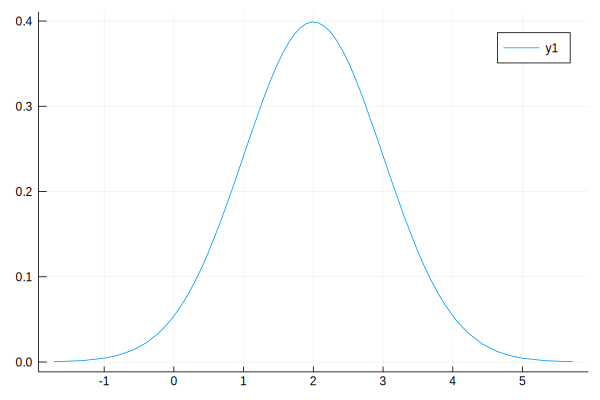

In [21]:
using StatsPlots
d=Normal(2.0,1.0)
plot(d) #note no other arguments!

## Creating own distribution type

In [23]:
struct OurTruncatedExponential <: Distribution{Univariate,Continuous}
    α::Float64
    xmax::Float64
end
Distributions.pdf(d::OurTruncatedExponential,x)=d.α*exp(-d.α*x)/exp(-d.α*d.xmax)
Distributions.minimum(d::OurTruncatedExponential)=0
Distributions.maximum(d::OurTruncatedExponential)=d.xmax

In [24]:
d=OurTruncatedExponential(1.0,2.0)
@show minimum(d),maximum(d)
@show support(d)

(minimum(d), maximum(d)) = (0, 2.0)
support(d) = RealInterval(0.0, 2.0)


RealInterval(0.0, 2.0)

**NOTE** support() does work even though we did not provide one (this is included in `Distributions.jl`).

`Distributions.support(d::Distribution) = RealInterval(minimum(d), maximum(d))`

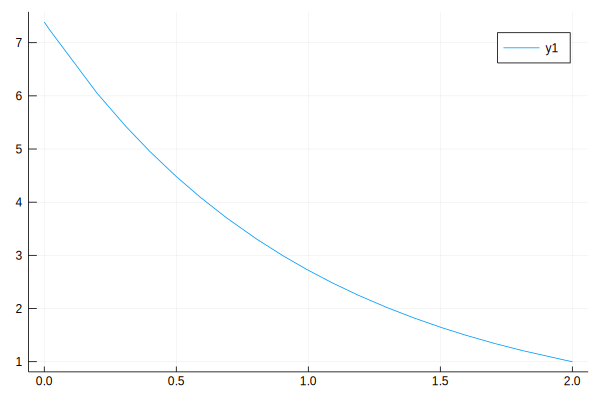

In [25]:
plot(d)

In [26]:
typeof(d)

OurTruncatedExponential

**NOTE**: our own distribution is breaking the implicit contract of the `Sampleable` abstract type, because we did not implement the `rand` function.

Using built-in functions of `Distributions` is better.

typeof(d) = Truncated{Exponential{Float64},Continuous,Float64}


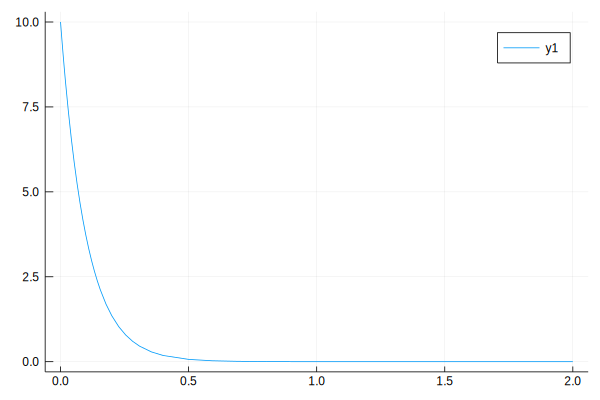

In [27]:
d = Truncated(Exponential(0.1),0.0,2.0)
@show typeof(d)
plot(d)

# Numbers and Algebraic Structures

## A ring 

The core of generic programming is that, given the knowledge that a value is of type Number, we can design algorithms using any of these functions and not concern ourselves with the particular concrete type.

In [28]:
a = 1.0 + 1.0im
b = 0.0 + 2.0im
@show typeof(a)
@show typeof(a) <: Number
@show a + b
@show a * b
@show -a
@show a - b
@show zero(a)
@show one(a);

typeof(a) = Complex{Float64}
typeof(a) <: Number = true
a + b = 1.0 + 3.0im
a * b = -2.0 + 2.0im
-a = -1.0 - 1.0im
a - b = 1.0 - 1.0im
zero(a) = 0.0 + 0.0im
one(a) = 1.0 + 0.0im


* `BigInt` is still included in `Number`

In [29]:
a = BigInt(10)
b = BigInt(4)
@show typeof(a)
@show typeof(a) <: Number
@show a + b
@show a * b
@show -a
@show a - b
@show zero(a)
@show one(a);

typeof(a) = BigInt
typeof(a) <: Number = true
a + b = 14
a * b = 40
-a = -10
a - b = 6
zero(a) = 0
one(a) = 1


## Complex Numbers and Composition of Generic Functions

In [30]:
x = 4.0 + 1.0im
@show x, typeof(x)

xbig = BigFloat(4.0) + 1.0im
@show xbig, typeof(xbig);

(x, typeof(x)) = (4.0 + 1.0im, Complex{Float64})
(xbig, typeof(xbig)) = (4.0 + 1.0im, Complex{BigFloat})


In [31]:
@which +(x,x)

+(z::Complex, w::Complex) in Base at complex.jl:275

In [32]:
? @which

```
@which
```

Applied to a function or macro call, it evaluates the arguments to the specified call, and returns the `Method` object for the method that would be called for those arguments. Applied to a variable, it returns the module in which the variable was bound. It calls out to the `which` function.


In [34]:
@which abs(x)

abs(z::Complex) in Base at complex.jl:264

In [35]:
@which abs(1.0)

abs(x::Float64) in Base at float.jl:528

In [36]:
@which abs(BigFloat(1.0))

abs(x::Real) in Base at number.jl:120

* Main Point

With a well-designed set of abstract types and functions, the code can both be highly general and composable and still use the most efficient implementation possible.

# Reals and Algebraic Structures

## Type promotion

Can be inverted and ordered. Complex numbers are not ordered.

In [37]:
a = 1 // 10
b = 4 // 6
@show typeof(a)
@show typeof(a) <: Number
@show typeof(a) <: Real
@show inv(a)
@show a / b
@show a < b;

typeof(a) = Rational{Int64}
typeof(a) <: Number = true
typeof(a) <: Real = true
inv(a) = 10//1
a / b = 3//20
a < b = true


Note: `a/b=a*inv(b)`

In [38]:
@show typeof(inv(a))

typeof(inv(a)) = Rational{Int64}


Rational{Int64}

In [40]:
a=1//1
@show typeof(a)

typeof(a) = Rational{Int64}


Rational{Int64}

In [42]:
@show typeof(inv(3))

typeof(inv(3)) = Float64


Float64

**Type promotion**: A type can be converted to another to ensure an operation is possible by direct conversion between types (i.e., it can be independent of the type hierarchy)

In [43]:
@show Float64 <: AbstractFloat
@show BigFloat <: AbstractFloat
@show eps(Float64)
@show eps(BigFloat);

Float64 <: AbstractFloat = true
BigFloat <: AbstractFloat = true
eps(Float64) = 2.220446049250313e-16
eps(BigFloat) = 1.727233711018888925077270372560079914223200072887256277004740694033718360632485e-77


In [44]:
@which isless(1,2)

isless(x::Real, y::Real) in Base at operators.jl:346

In [45]:
isless(1.0,2.0)
@which isless(1.0,2.0)

isless(x::Float64, y::Float64) in Base at float.jl:465

* specilized implementation

# Functions, and Function-Like Types

* `quadgk`

Returns a pair (I,E) of the estimated integral I and an estimated upper bound on the absolute error E. 

quadgk(f, 0.0, 1.0) = (0.3333333333333333, 5.551115123125783e-17)


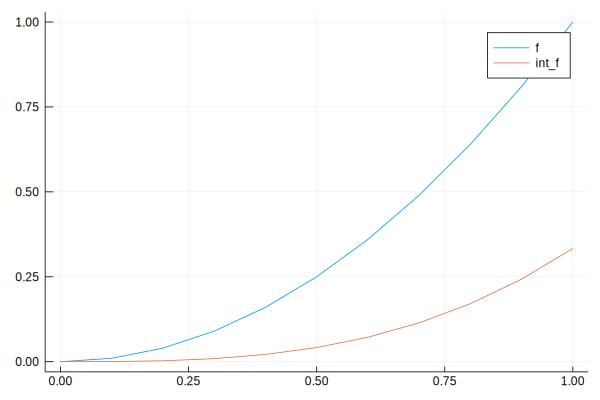

In [46]:
using QuadGK
f(x) = x^2
@show quadgk(f, 0.0, 1.0)  # integral

function plotfunctions(f)
    intf(x) = quadgk(f, 0.0, x)[1]  # int_0^x f(x) dx

    x = 0:0.1:1.0
    f_x = f.(x)
    plot(x, f_x, label="f")
    plot!(x, intf.(x), label="int_f")
end
plotfunctions(f)  # call with our f

p = Poly(2 - 5*x + 2*x^2)
p(1.0) = -1.0


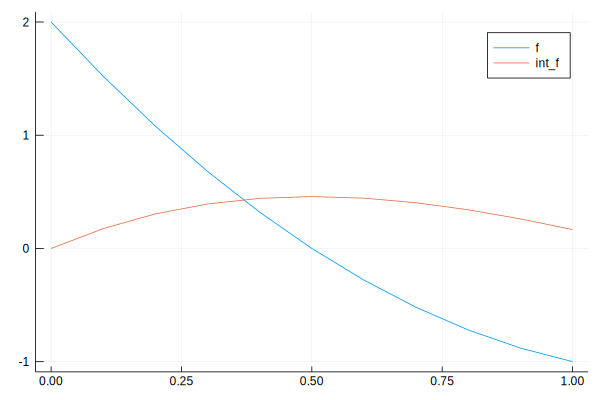

In [50]:
using Polynomials
p=Poly([2,-5,2],:x) #:x just gives a symbol for display
@show p
@show p(1.0) #like a function

plotfunctions(p)


In [54]:
@show typeof(p)

typeof(p) = Poly{Int64}


Poly{Int64}

**NOTE** : Even though the type of `p` is `Poly`, but p() works like a function.

f_int(1.0) = 1.0


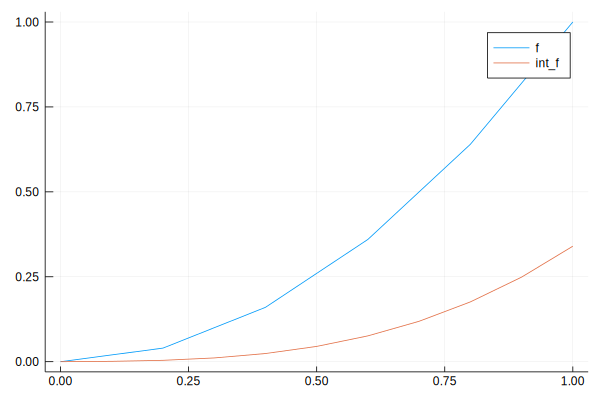

In [60]:
using Interpolations
x = 0.0:0.2:1.0
f(x) = x^2
f_int = LinearInterpolation(x, f.(x))  # interpolates the coarse grid
@show f_int(1.0)  # call like a function

plotfunctions(f_int)  # same generic function

This approach to design with types – generic, but without any specific type declarations – is called duck typing ("If it walks like a duck and it quacks like a duck, then it must be a duck").

# Limitations of Dispatching on Abstract Types

The tree structure has worked well for the above examples, but it doesn’t allow us to associate multiple categorizations of types.

For example, a semi-group type would be useful for a writing generic code (e.g. continuous-time solutions for ODEs and matrix-free methods), but cannot be implemented rigorously since the Matrix type is a semi-group as well as an AbstractArray, but not all semi-groups are AbstractArray s.

# Exercises

## Exercise 1a

In [108]:
using LinearAlgebra
function trap_weights(x)
    return step(x) * [0.5; ones(length(x) - 2); 0.5]
end
x = range(0.0, 1.0, length = 100)
ω = trap_weights(x)
f(x) = x^2
@time dot(f.(x), ω)

  0.021455 seconds (83.06 k allocations: 3.848 MiB)


0.3333503384008434

In [109]:
struct UniformTrapezoidal
    count::Int
    Δ::Float64
end

Base.iterate(S::UniformTrapezoidal,state=1)=(state>S.count) ? nothing : ((state==1) 
    || (state==S.count) ? (S.Δ*0.5 ,state+1) : (S.Δ, state+1))

function ex1a(x,f)
    ω=UniformTrapezoidal(length(x),step(x))
    return dot(f.(x),ω)
end

x=range(0.0,1.0,length=100)
f(x)=x^2
@time ex1a(x,f)


  0.045846 seconds (137.19 k allocations: 6.435 MiB)


0.3333503384008434

In [111]:
# Example of iterate
struct Squares
           count::Int
end
Base.iterate(S::Squares, state=1) = state > S.count ? nothing : (state*state, state+1)
for i in Squares(7)
    println(i)
end

1
4
9
16
25
36
49


In [112]:
sum(Squares(7))

140

In [117]:
Base.eltype(::Type{Squares})=Int
Base.length(S::Squares)=S.count
function Base.getindex(S::Squares,i::Int)
    1<=i<=S.count||throw(BoundsError(S,i))
    return i*i
end

Base.firstindex(S::Squares)=1
Base.lastindex(S::Squares)=length(S)
Squares(0)[end]

BoundsError: BoundsError: attempt to access Squares
  at index [0]

## Exercise 1b :INCOMEPLTE

In [123]:
struct UniformTrapezoidal2<:AbstractArray{Float64,1}
    count::Int
    Δ::Float64
end
Base.size(S::UniformTrapezoidal2)=(S.count,)
Base.IndexStyle(::Type{<:UniformTrapezoidal2})=IndexLinear()
Base.getindex(S::UniformTrapezoidal2,state=1)=(state>S.count) ? nothing : ((state==1) 
    || (state==S.count) ? (S.Δ*0.5 ,state+1) : (S.Δ, state+1))

ω=UniformTrapezoidal2(length(x),step(x))
length(f.(x)),length(ω)
#==
function ex1a(x,f)
    ω=UniformTrapezoidal2(length(x),step(x))
    return dot(f.(x),ω)
end

x=range(0.0,1.0,length=100)
f(x)=x^2
@time ex1a(x,f)
==#


(100, 100)

With this, you should be able it go ω[2] or length(ω) to access the quadrature weights.

## Exercise 2

In [116]:
? eltype

search: eltype fieldtype fieldtypes base_color_type base_colorant_type



```
eltype(type)
```

Determine the type of the elements generated by iterating a collection of the given `type`. For dictionary types, this will be a `Pair{KeyType,ValType}`. The definition `eltype(x) = eltype(typeof(x))` is provided for convenience so that instances can be passed instead of types. However the form that accepts a type argument should be defined for new types.

# Examples

```jldoctest
julia> eltype(fill(1f0, (2,2)))
Float32

julia> eltype(fill(0x1, (2,2)))
UInt8
```

---

```
eltype(sc)
```

Returns the (key,value) type (a 2-entry pair, i.e., `Pair{K,V}`) for SortedDict and SortedMultiDict. Returns the key type for SortedSet. This function may also be applied to the type itself. Time: O(1)

---

```
eltype(sc)
```

Returns the (key,value) type (a 2-entry pair, i.e., `Pair{K,V}`) for SortedDict and SortedMultiDict. Returns the key type for SortedSet. This function may also be applied to the type itself. Time: O(1)

---

```
eltype(sc)
```

Returns the key type for SortedSet. This function may also be applied to the type itself. Time: O(1)

---

```
eltype(s::Sampleable)
```

The default element type of a sample. This is the type of elements of the samples generated by the `rand` method. However, one can provide an array of different element types to store the samples using `rand!`.

---

```
eltype(d::MultivariateDistribution)
```

Return the sample type of distribution `d`
